# Import Libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import tensorflow as tf
from matplotlib import pyplot
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Add Path and Other Setting

In [18]:
# Path To Image Directory
PATH = "./Defect_classes/"

# Image Shape to Be trained
image_size=227

# Batch size to feed in the model
batch_size=16

In [19]:
# Train Dataset
train_data_dir = f'{PATH}train'

#Validation Dataset
validation_data_dir = f'{PATH}valid'

# Data Augmentation and Preprocessing

## Data Augmentation

For Help open https://towardsdatascience.com/data-augmentation-techniques-in-python-f216ef5eed69

In [20]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, #rescale=1./255 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   rotation_range=10)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)#rescale=1./255

In [21]:
# Available options for data augmentation

# ImageDataGenerator(
#     featurewise_center=False, samplewise_center=False,
#     featurewise_std_normalization=False, samplewise_std_normalization=False,
#     zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
#     height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
#     channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
#     vertical_flip=False, rescale=None, preprocessing_function=None,
#     data_format=None, validation_split=0.0, dtype=None
# )

## Preprocessing Data

In [22]:
train_generator = train_datagen.flow_from_directory(train_data_dir,                                                
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size, 
                                                    class_mode='sparse'
                                                   )

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        shuffle=False,
                                                        target_size=(image_size, image_size),
                                                        batch_size=batch_size, class_mode='sparse'
                                                       )   

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [23]:
# Check Category of classes
train_generator.class_indices

{'No_crack': 0, 'crack': 1}

In [24]:
train_generator.num_classes

2

## Visualize few images from Data generated set (Original and augmented images)

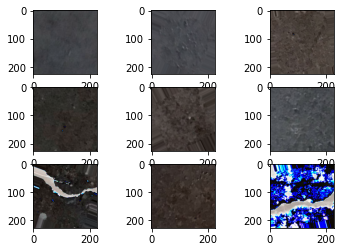

In [25]:
# generate samples and plot
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    x,y = train_generator.next()
    # convert to unsigned integers for viewing
    image = x[0].astype('uint8')
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [26]:
# x[i]

In [27]:
image.shape

(227, 227, 3)

# Define Pretrained Model, Layers and other Parameters

## Add Pretrained Model Layer

To find more about Pretrained models open https://keras.io/api/applications/

In [28]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape = (image_size, image_size, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Freeze Pretrained Model

#### Method 1 ( Freeze all layers in pretrained model )

In [29]:
# base_model.trainable = False

#### Method 2 ( Freeze All layers in Pretarined Model Except Batch Normalization Layers )

In [30]:
#Freeze All layers in Pretarined Model Except Batch Normalization Layers
for layer in base_model.layers:
    if layer.__class__.__name__ != "BatchNormalization":
        layer.trainable = False

In [31]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 233, 233, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 114, 114, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 114, 114, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [32]:
# #Adding custom Layers 

# x = base_model.output
# x = Flatten()(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(0.3)(x)
# x = Dense(124, activation="relu")(x)
# out = Dense(2, activation="softmax")(x)

In [33]:
#Fastai Like Converging last few layers

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
mx = tf.keras.layers.GlobalMaxPooling2D()(base_model.output)
out = tf.keras.layers.Concatenate()([avg, mx])
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dropout(0)(out)
out = tf.keras.layers.Dense(512, activation="relu")(out)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dropout(0)(out)
out = tf.keras.layers.Dense(2, activation="softmax")(out)

In [34]:
# creating the final model by combining pretrained model and custom layers.
model_final = Model(inputs = base_model.input, outputs = out)

## Define optimizer, Loss and Early Stopping

In [35]:
# compile the model 
# optimizer = tf.keras.optimizers.Adam(lr=0.003)
optimizer = tf.keras.optimizers.Adam()
model_final.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])

In [36]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 233, 233, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 114, 114, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 114, 114, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

For more info on Early Stopping https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In [37]:
# simple early stopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1)

In [38]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Train Your Model

Our aim is to get higher accuracy and generalize better
https://deeplearningdemystified.com/article/fdl-5

In [41]:
#Set number of Epochs (Cycles to run)
epochs = 1

In [42]:
history=model_final.fit_generator(train_generator,steps_per_epoch=train_generator.n // batch_size,epochs=epochs,
                                  validation_data=validation_generator,
                                  validation_steps=validation_generator.n // batch_size,
                                  verbose=1 
                                  #callbacks=[es, mc]
                                 )

125/125 [==============================] - 1719s 14s/step - loss: 0.1050 - acc: 0.9775 - val_loss: 0.0091 - val_acc: 0.9975


Tips:

Overfitting if: training loss << validation loss

Underfitting if: training loss >> validation loss

Just right if training loss ~ validation loss

## Fine Tunning

In [44]:
model_final.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model_final.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

## Visualize failed prediction from train and valid dataset


In [43]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [54]:
# View images with failed prediction from validation dataset
interpret = test_datagen.flow_from_directory(validation_data_dir,
                                                        shuffle=False,
                                                        target_size=(image_size, image_size),
                                                        batch_size = 1,
                                                        class_mode='sparse'
                                                       )  

Found 400 images belonging to 2 classes.


In [54]:
# View images with failed prediction from trian dataset
# interpret = test_datagen.flow_from_directory(train_data_dir,
#                                                         shuffle=False,
#                                                         target_size=(image_size, image_size),
#                                                         batch_size = 1,
#                                                         class_mode='sparse'
#                                                        )  

Found 1000 images belonging to 2 classes.


In [55]:
y_pred =model_final.predict_generator(interpret)
y_pred_ind = np.argmax(y_pred, axis=1)

In [56]:
print(confusion_matrix(interpret.classes, y_pred_ind))

[[199   1]
 [  0 200]]


In [57]:
fnames = interpret.filenames
errors = np.where(y_pred_ind != interpret.classes)[0]
for i in errors:
    print(fnames[i])

No_crack\01161.jpg


In [58]:
errors

array([160], dtype=int64)

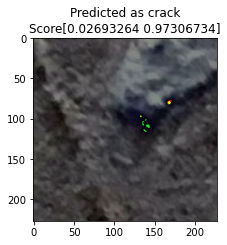

In [59]:
import numpy as np
import matplotlib.pyplot as plt

labels = {0 : 'No_crack', 1 : 'crack'}
rows = 5
cols = 3
axes=[]
fig=plt.figure(figsize=(15, 15))

for a in range(len(errors)):
    # generate batch of images
    x,y = interpret[errors[a]]
    # convert to unsigned integers for viewing
    image = x[0].astype('uint8')
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Predicted as "+str(labels[y_pred_ind[errors[a]]]+ '\n' + "Score" + str(y_pred[errors[a]])))
    axes[-1].set_title(subplot_title)  
    plt.imshow(image)
fig.tight_layout()    
plt.show()

In [60]:
str(y_pred[errors[a]][y_pred_ind[a]])

'0.026932642'

In [61]:
len(fnames)

400

##  Save .H5 File 

In [53]:
model_final.save('crackclassifier_model.h5')